# Programing exercise 9: Linblad master equation, EIT

Due on Monday, 14.01.2019, 14.15h

### Total: 100 points

## The problem

Light propagating through an atomic medium is usually scattered and thus absorbed thorough near-resonant coupling to a transition from the ground ($|g_1\rangle$) to an excited ($|e\rangle$) electronic state. If a second light field ("coupling laser") couples the excited state to a third, long-lived, state ($|g_2\rangle$), the medium can again become transparent for the first light field ("probe laser"). This effect, called electromagnetically induced transparency (EIT) - the above description referring to the lambda confuration for obvious reasons - has led to a plethora of applications, see e.g. Rev. Mod. Phys. 77, 633 (2005) [1]. The dynamics of the atomic populations can be simulated using the Lindbald master equation approach, accounting for the coherent driving laser fields, and incoherent processes such as spontaneous emission and dephasing, e.g. due to finite laser linewidth. The complex refractive index of the atomic medium is given by $n=\sqrt{1+\chi}\approx 1 + (\chi_R + \chi_I)/2$, where the real and imaginary part of complex  susceptibility $\chi$ account for diffraction and absorption of the probe light respectively. $\chi$ depends on the polarizability of the atomic dipoles in the medium and is thus proportional to expectation value of the operator $|g_1\rangle \langle e|$, i.e. $\rm{tr}[|g_1\rangle \langle e| \rho] = \langle e| \rho |g_1 \rangle = \rho_{eg_1}$. This coherence will thus be the main object of interest.

The interaction with the laser fields is described by the Hamiltonian (in rotating wave approximation, in the basis $\{|g_1\rangle,|g_2\rangle,|e\rangle\}$, following the sign convention used in [1])
$$
H=\left[
\begin{array}{ccc}
0 & 0 & -\Omega_p/2 \\
0 & \Delta_p-\Delta_c & -\Omega_c/2 \\
-\Omega_p/2 & -\Omega_c/2 & \Delta_p
\end{array}
\right]
$$
where $\Omega$'s are Rabi-frequencies and $\Delta$'s are the detunings of the lasers from the respective atomic transitions. $\Delta_p-\Delta_c$ is the "two-photon-detuning" sometimes abbreviated as $\delta_2$.

The dissipative processes we want to consider are the spontaneous emission from $e$ to both ground states $g_1$ and $g_2$ and later also the decay from $g_2$ to $g_1$, which breaks the EIT. These are accouted for by the jump operators
$$
\Gamma_{eg_1} = \sqrt{\gamma_p} |g_1\rangle \langle e|, \quad \Gamma_{eg_2} = \sqrt{\gamma_c} |g_2\rangle \langle e|, \quad\Gamma_{g_2g_1} = \sqrt{\gamma_g} |g_1\rangle \langle g_2| .
$$
The resulting master equation reads
$$
\dot\rho = -i[H,\rho] + \mathcal{L}_{\Gamma_{eg_1}} [\rho]+ \mathcal{L}_{\Gamma_{eg_2}} [\rho]+ \mathcal{L}_{\Gamma_{g_2g_1}} [\rho]
$$
with the Lindblad superoperator
$$
\mathcal{L}_{\Gamma_x} [\rho] = \Gamma_x \rho \Gamma_x^\dagger - \frac{1}{2}(\Gamma_x^\dagger\Gamma_x \rho + \rho \Gamma_x^\dagger\Gamma_x)
$$

In [129]:
# load standard libraries

import numpy as np   # standard numerics library
import numpy.linalg as LA
import matplotlib.pyplot as plt   # for making plots
%matplotlib inline

### Exercise 1 (40 points)

Set up the Liouvillian matrix. Check your implementation by calculating the steady state for the case of zero two-photon detuning (and $\gamma_{g}=0$), where the steady state is the pure state ("dark state")
$$
|d\rangle = \frac{\Omega_c |g_1\rangle - \Omega_p |g_2\rangle}{\sqrt{\Omega_p^2 + \Omega_c^2}}.
$$

Detailed instructions (You can of course proceed differently if you want. I am pretty sure the method described in the following is not the most elegant one...):
- Building the Liouvillian in matrix form: We want to formulate the master equation in the standard form of an ordinary differnetial equation $\dot\rho = \mathcal{L} \rho$ with $\rho$ the density matrix in vector form and $\mathcal{L}$ a matrix summarizing the right hand side of the master equation. However, the master equation is more conveniently formulated using dot-products between matrices representing operators in Hilbert space. Therefore, it is makes sense to write a function that takes the vectorized density matrix as an input (along with the Hamiltonian matrix and the jump operators used in the Lindblad terms), converts it into a matrix using reshape() calculates the right hand side of the master equation and returns the result in vector form by using reshape again. To build the Liouvillian matrix you can pass all the projectors $|i\rangle\langle j|$ to this function. Those are the unitvectors spanning the space of vectorized density matrices. The outputs will be the columns of the Liouvillian matrix.
- Calculating steady states: The steady state is the unique state for which the right hand side of the master equation gives zero. Calculating this is less trivial than it seems. If we just try solving the linear system of equations $\mathcal{L}\rho = 0$ it wont work since $\rho=0$ is always a trivial solution. We need to ensure that the trace of the density matric is 1. This can be achieved by dropping the first line of the master equation ($\dot\rho_{g_1g_1}=...$) and replacing $\rho_{g_1g_1} = 1-\rho_{g_2g_2}-\rho_{ee}$ everywhere. The resulting inhomogeneous system of 8 equations can be solved using np.linalg.solve(). $\rho_{g_1g_1}$ can be prepended to the solution by using the trace condition again. There are many other ways to calculate steady states, see for example the qutip documentation (http://qutip.org/docs/4.0.2/guide/guide-steady.html). You can of course also use qutip routines to check your results.

In [130]:
#possible states
g1=np.array([1,0,0])
g2=np.array([0,1,0])
e=np.array([0,0,1])

In [131]:
#defininig jump operators
def jump_op(p,c,g):
    jeg1=np.sqrt(p)*np.outer(g1,e)
    jeg2=np.sqrt(c)*np.outer(g2,e)
    jg2g1=np.sqrt(g)*np.outer(g1,g2)
    jump=[jeg1,jeg2,jg2g1]
    return jump

#definiton of hamilton matrix
def hamiltonian(Omp,Omc,delc,delp):
    return np.array([[0,0,-Omp/2],[0,delp-delc,-Omc/2],[-Omp/2,-Omc/2,delp]])
#righthandside calculation, the density matrix is given as a vector
def righthandside(Hamilton,density,jump):
    density = np.reshape(density, (3,3))
    #lindblads
    righthand=-1j*(Hamilton@density -density @Hamilton)
    for jumpop in jump:
        righthand = righthand+(jumpop @ density @np.transpose(jumpop) -1/2*(np.transpose(jumpop) @ jumpop @ density + 
        density @ np.transpose(jumpop) @ jumpop))
    return np.reshape(righthand, (9))


In [132]:
#calculating the liouvillian matrix elements
def liouvillian(Hamilton,jump):
    L = np.zeros((9,9),dtype=complex) 
    for i in range(9):
    
        densityi = np.zeros(9)
        densityi[i] = 1 
        L[:, i] = righthandside(Hamilton,densityi,jump)
    return L

In [133]:
#calculating the steady state applying the needed correction for rhoee
def steady_state(L):
    A = L[1:,1:]
    column = L[1:,0]
    
    for i in range(len(column)):
        A[i, 3] -= column[i]
        A[i, 7] -= column[i]
        
    x = LA.solve(A,-column)
    
    steady = np.zeros(9, dtype = complex)
    steady[1:] = x
    steady[0] = 1-steady[4]-steady[8]
    return steady  
gamp,gamc,gamg =1, 1, 1
L = liouvillian(hamiltonian(1,1,1,1),jump_op(gamp,gamc, gamg))
steady = steady_state(L)
print(steady)

[ 0.81940701+6.66191905e-18j -0.14016173-1.13207547e-01j
  0.12398922-1.80592992e-01j -0.14016173+1.13207547e-01j
  0.11051213-2.60208521e-18j  0.01078167+4.04312668e-02j
  0.12398922+1.80592992e-01j  0.01078167-4.04312668e-02j
  0.07008086-4.05983383e-18j]


### Exercise 2 (20 points)

Scan the probe detuning $\Delta_p$ at resonant coupling beam ($\Delta_c=0$). Plot imaginary and real part of the steady state $\rho_{eg_1}$ as a function of $\Delta_p$. Start with parameters $\Omega_p=\Omega_c=\gamma_p=1$ and all other parameters zero. You should see the charactersitic EIT dip in the absorption (see Fig. 1 in [1]). Then change the coupling Rabi frequency to a larger value to see what happens (Fig. 7 in [1]). Can you interpret the result in the dressed-state picture? Also change $\gamma_p$ and $\gamma_c$ and describe your observation. In principle, $\gamma_p$ can be set to 1, defining the energy scale. In this exercise the focus is on exploring the physics of the problem and interpreting the numerical results.

In [139]:
#defining parameters
gamp,gamc,gamg= 1, 0, 0
Delta_p,delc =np.linspace(-3,3,100),0
Omep,Omec=1,1

#testing implementation with eg1 and plotting the steady state solutions real and imaginary part for different dp
steady_real = []
steady_imag = []
for dp in Delta_p:
    L = liouvillian(hamiltonian(Omep,Omec,delc,dp),jump_op(gamp,gamc,gamg))
    #eg1 component of the steady state
    steady = steady_state(L)[6] 
    steady_real.append(steady.real)
    steady_imag.append(steady.imag)

Text(0,0.5,'steady state solution real/imaginary')

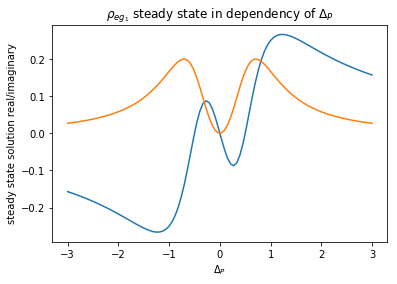

In [140]:
#Plotting the results
plt.plot(Delta_p, steady_real)
plt.plot(Delta_p, steady_imag)
plt.title(r"$\rho_{e g_1}$ steady state in dependency of $\Delta_P$")
plt.xlabel("$\Delta_P$")
plt.ylabel("steady state solution real/imaginary")

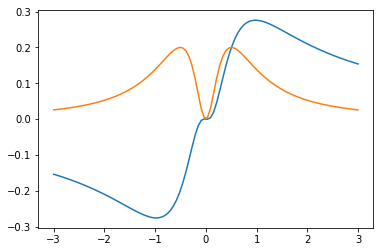

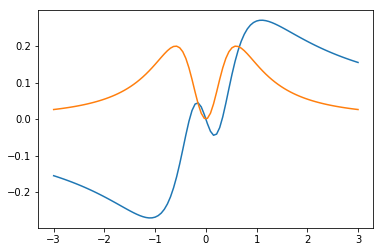

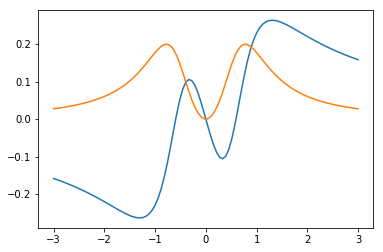

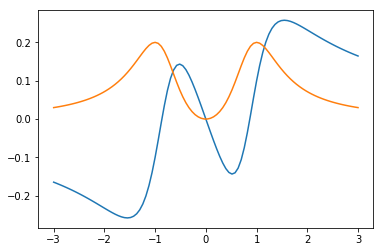

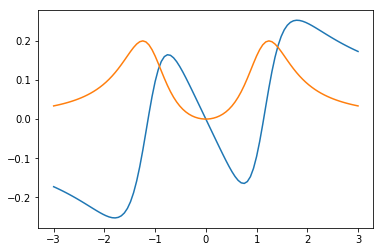

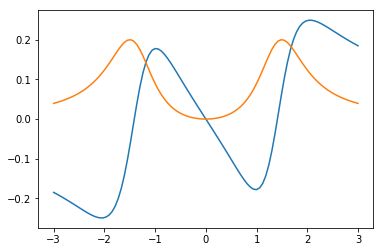

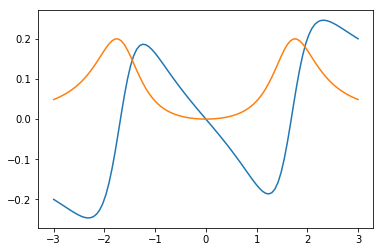

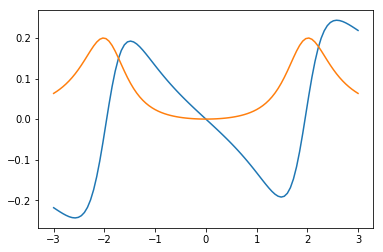

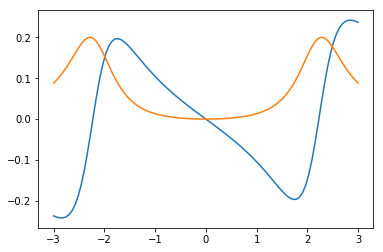

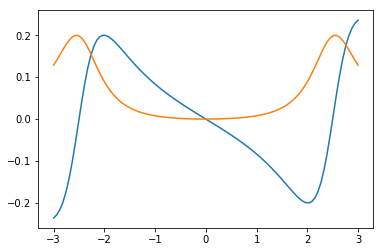

In [136]:
#looking at different omegac
Omec = np.linspace(0.1,5,10)
for omec in Omec:
    steady_real = []
    steady_imag = []
    for dp in Delta_p:
        L = liouvillian(hamiltonian(Omep, omec,delc,dp),jump_op(gamp,gamc,gamg))

        steady = steady_state(L)[6] 
        steady_real.append(steady.real)
        steady_imag.append(steady.imag)
    #Plotting the results
    plt.plot(Delta_p, steady_real)
    plt.plot(Delta_p, steady_imag)
    plt.show()

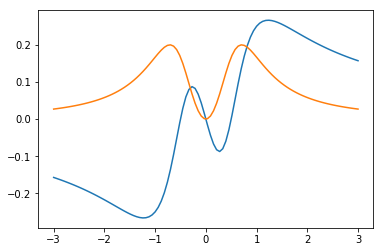

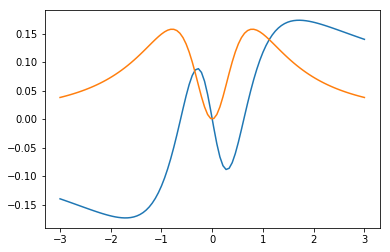

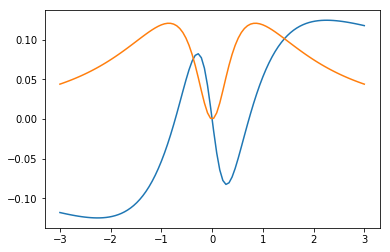

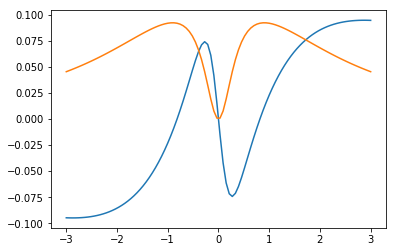

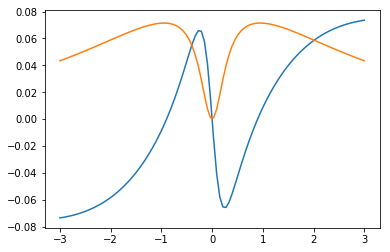

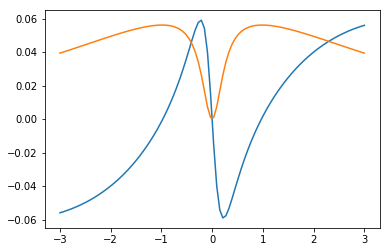

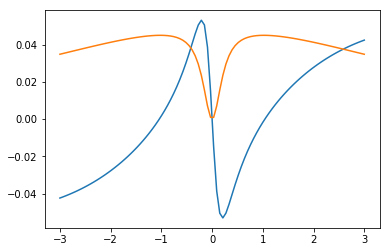

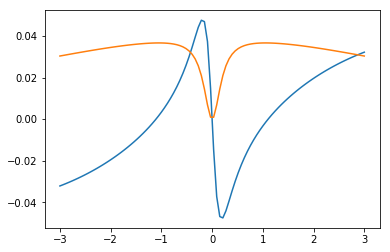

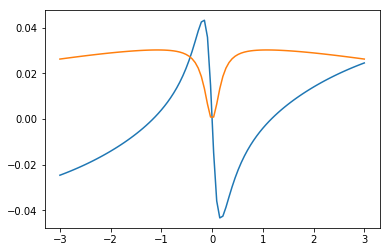

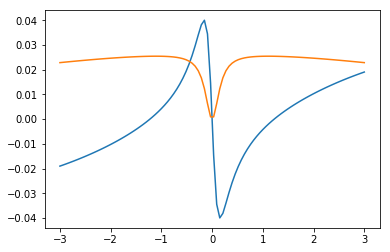

In [137]:
#looking at different jump strenghts
gamc = np.linspace(0,5,10)
for gamma in gamc:
    steady_real = []
    steady_imag = []
    for dp in Delta_p:
        L = liouvillian(hamiltonian(Omep, 1,delc,dp),jump_op(gamp,gamma,gamg))
        #eg1 component of the steady state
        steady = steady_state(L)[6] 
        steady_real.append(steady.real)
        steady_imag.append(steady.imag)
    #Plotting the results
    plt.plot(Delta_p, steady_real)
    plt.plot(Delta_p, steady_imag)
    plt.show()

### Exercise 3 (10 points)

Now add a spontaneous decay from $g_2$ to $g_1$. Make the same plots as in Exercise 2 for a fixed value of in $\Omega_c=2\gamma$ and various values of $\gamma_{g}$. What do you observe? Compare to Fig. 10 in [1].

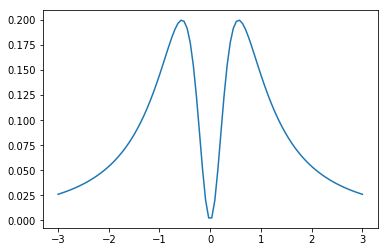

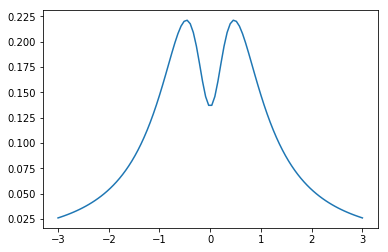

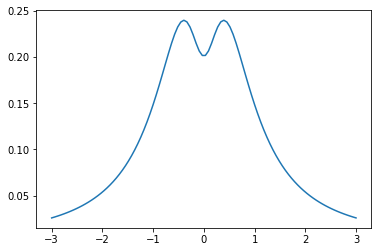

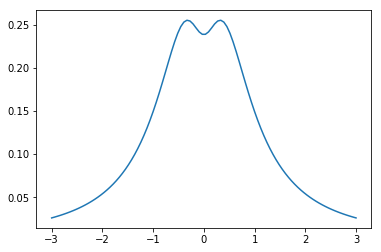

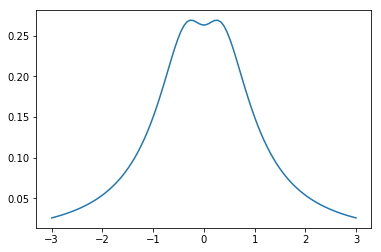

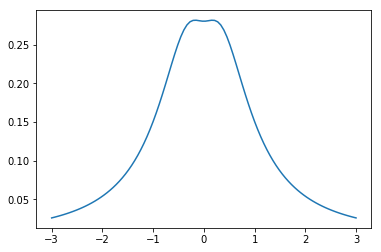

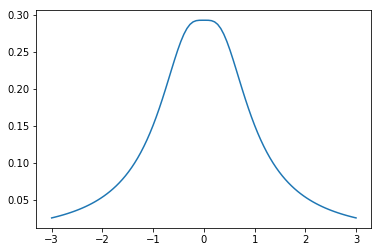

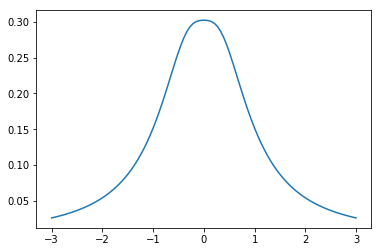

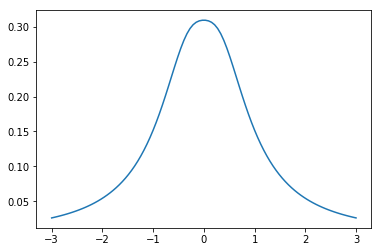

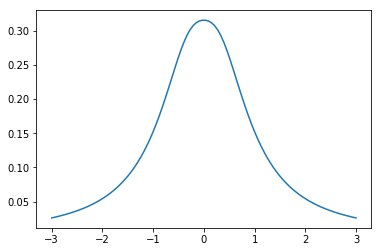

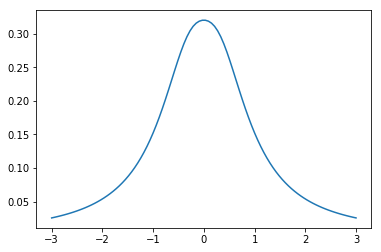

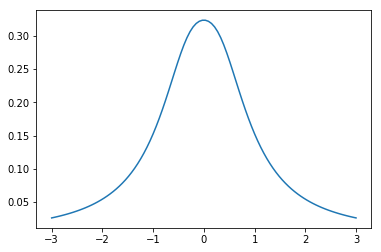

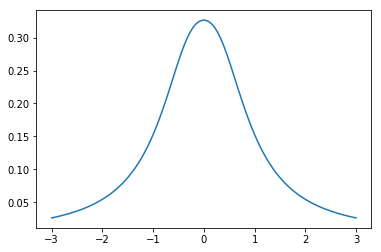

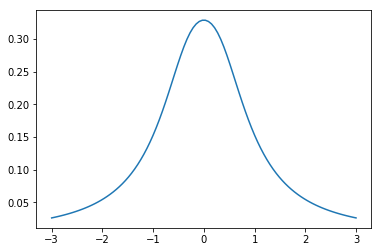

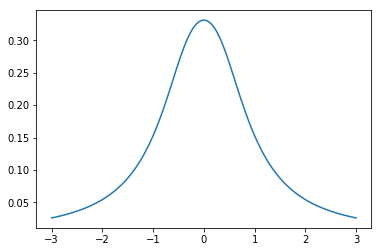

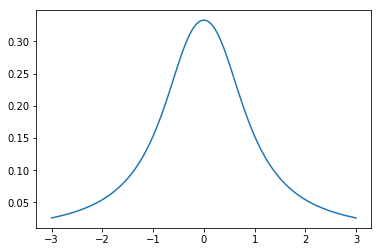

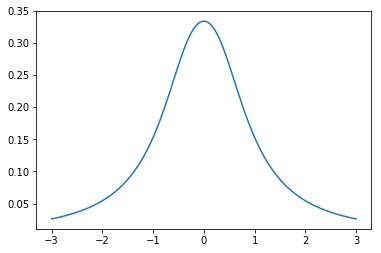

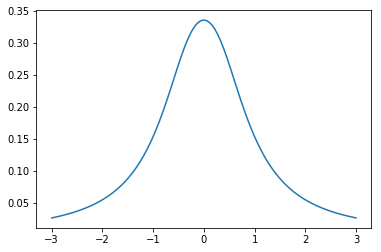

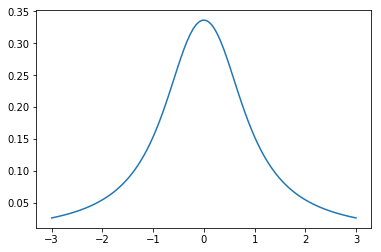

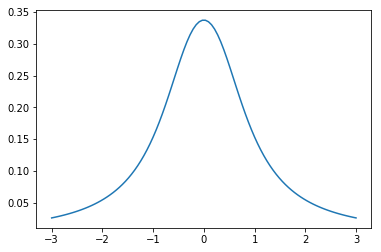

In [138]:
#looking at different jump strenghts
Omec, Omep, gamp, gamc, gammag= 0.5, 1, 1, 0, np.linspace(0,1,20)

for gamma in gammag:
    steady_real = []
    steady_imag = []
    for dp in Delta_p:
        L = liouvillian(hamiltonian(Omep,Omec,delc,dp),jump_op(gamp,gamc,gamma))
        
        steady = steady_state(L)[6] 
        steady_real.append(steady.real)
        steady_imag.append(steady.imag)
    #Plotting the results
    plt.plot(Delta_p, steady_imag)
    plt.show()

### Exercise 4 (30 points)

Dynamics: Solve the Master equation time-dependently with initial state $\rho_0 = |g_1\rangle \langle g_1| \rho$. You can use a scipy intergrator, for example the one used on exercise sheet 5. Plot the populations of the levels and the real and imaginary part of $\rho_{eg_1}$ as a function of time. Good example parameters are $\Omega_p = 1, \Omega_c = \gamma_p = 2$ and the others zero, integrating to t=10. Check qualitatively how the time for approaching the steady state depends on the parameters, expecially on $\Omega_c$ and $\Gamma_p$.